### This code is based on code by Sigman and co-workers (https://github.com/SigmanGroup)

Contributors to the original code by Sigman and co-workers: Tobias Gensch, Cian Kingston, Iris Guo, Ellyn Peters, Jen Crawford, and Cian Kingston

Code for the statistical analysis of MLR models is by Jonas Rein

# Imports

In [21]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed
from scipy.stats.stats import pearsonr   


import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="red",marker="s")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    
#     plt.xticks([])
#     plt.yticks([])
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

# Reading data

In [19]:
# all data in a single file
excel_file = "Azide IS"
excel_sheet = "X-Ray Confomers (Azide)"
num_par = 169 # number of descriptors
par_start_col = 5 # 0-indexed
num_samples = 29 # number of compounds
response_col = 2 # 0-indexed
y_label_col = 0 # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True
meanfilldata = True # Meanfill missing data

inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if meanfilldata:
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])
    #pd.DataFrame(X).to_excel('withaverage.xlsx') for testing the meanfilling

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())


n_samples before removing empty cells: 29
Removing 6 samples.
Shape X: (23, 169)
Shape y: (23,)
Shape labels: (23,)
First X cell: 1.8294
Last X cell:  12.599999999999998
First y: 1.0
Last y:  0.397940009
Last label: A29


### Correlation Map

<IPython.core.display.Javascript object>


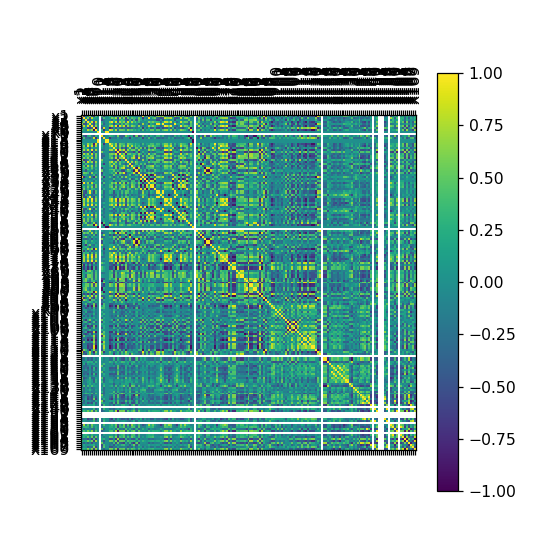

In [20]:
%matplotlib notebook
# this will open an interactive plot that you can enlarge and zoom into


corrmap = np.corrcoef(X.T)
plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

# Data preparation: Training/Test set split, Scaling

TS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
VS: [14, 15, 16, 17, 18, 19, 20, 21, 22]
y_mean TS: 0.447
y_mean VS: 0.666
Shape X_train: (14, 169)
Shape X_test:  (9, 169)


<IPython.core.display.Javascript object>


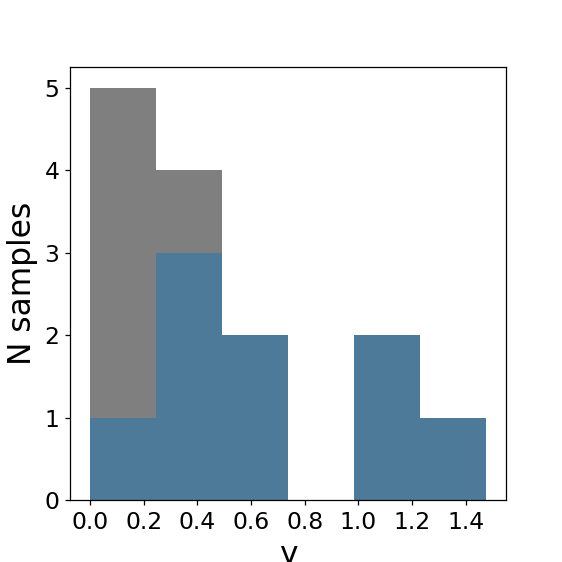

In [5]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "define"
test_ratio = 0.01

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    TS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
    VS = [14,15,16,17,18,19,20,21,22]
    #[6]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Feature Scaling 

In [6]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

# Multivariate Linear Regression (Forward Selection)

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 14.8638
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Done. Time taken (minutes): 1.55


Best model:
1 + x165 + x168 + x5
1 + dnorm min + CN + N2 - N3 BD(1) occ

Features: x5 + x165 + x168

Parameters:
    0.4468 + 
    0.2925 * x5 N3 LP(1) occ
    0.4072 * x165 OH+HO+NH+HO
    0.2082 * x168 all C

Training R2  = 0.895
Training Q2  = 0.831
Training MAE = 0.109
Training K-fold R2 = 0.792 (+/- 0.004)

Test R2      = -0.093
Test MAE     = 0.444


<IPython.core.display.Javascript object>


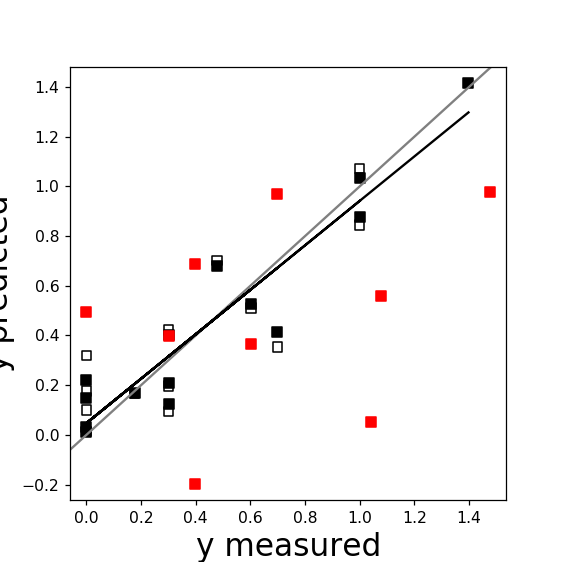

In [11]:
n_steps = 3 #number of terms in model.
n_candidates = 169
collin_criteria = 0.5 # the maximum R2 between terms
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print("\n\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

In [12]:
# view best models
results.sort_values(by=['n_terms','Q^2'],ascending=[True,False])
listofmodels = results['Model'].tolist()
print(listofmodels)
results.to_excel('Azide IS all MLR models.xlsx')

[('x165', 'x168', 'x5'), ('x165', 'x168', 'x42'), ('x165', 'x168', 'x48'), ('x165', 'x168', 'x40'), ('x164', 'x169', 'x40'), ('x164', 'x169', 'x42'), ('x164', 'x169', 'x5'), ('x164', 'x169', 'x48'), ('x165', 'x168', 'x39'), ('x164', 'x168', 'x5'), ('x164', 'x168', 'x42'), ('x164', 'x168', 'x40'), ('x164', 'x168', 'x48'), ('x168', 'x169', 'x48'), ('x168', 'x169', 'x5'), ('x168', 'x169', 'x42'), ('x168', 'x169', 'x40'), ('x149', 'x164', 'x39'), ('x164', 'x169', 'x94'), ('x149', 'x169', 'x39'), ('x131', 'x163', 'x164'), ('x149', 'x164', 'x40'), ('x149', 'x164', 'x48'), ('x149', 'x164', 'x5'), ('x149', 'x164', 'x42'), ('x133', 'x160', 'x168'), ('x128', 'x163', 'x164'), ('x155', 'x164', 'x48'), ('x155', 'x164', 'x40'), ('x155', 'x164', 'x42'), ('x155', 'x164', 'x5'), ('x149', 'x165', 'x39'), ('x165', 'x168', 'x94'), ('x108', 'x131', 'x164'), ('x105', 'x131', 'x164'), ('x149', 'x165', 'x5'), ('x149', 'x165', 'x42'), ('x149', 'x165', 'x48'), ('x149', 'x165', 'x40'), ('x155', 'x165', 'x42'), (

### Visulazation of a MLR model

Features: x128 + x163 + x164

Parameters:
    0.4468 +     0.2655 * x128 di mean
   -0.4539 * x163 HH
   -0.7309 * x164 OO+ON+NO+NN

Training R2  = 0.826
Training Q2  = 0.703
Training MAE = 0.136
Training K-fold R2 = 0.629 (+/- 0.018)

Test R2      = 0.551
Test MAE     = 0.272


<IPython.core.display.Javascript object>


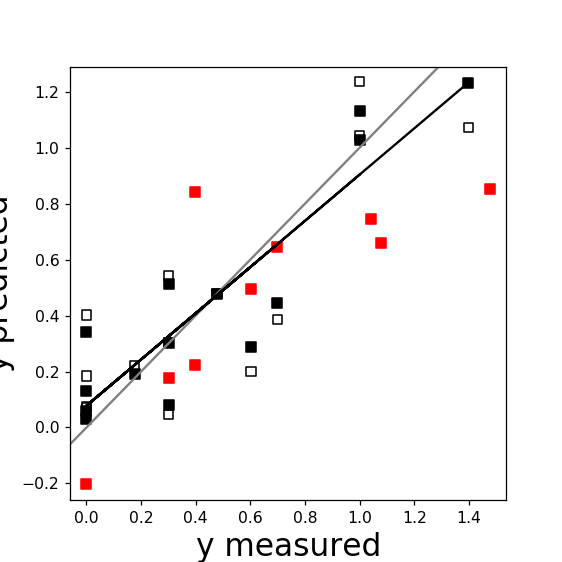

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     15.82
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           0.000399
Time:                        17:47:09   Log-Likelihood:                 4.3216
No. Observations:                  14   AIC:                           -0.6433
Df Residuals:                      10   BIC:                             1.913
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4468      0.056      7.951      0.0

In [22]:
#provide an x__ model (string, any order of terms)

features_x = "x164 + x163 + x128" 
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = LinearRegression().fit(X_train_sel, y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=4,n=200)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + ".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

# Statistical Analysis of the Forward Selected MLR models
##### This counts the occurrence of each term in the whole list of models with the sign of their coeffecients (positive, negative, net, abs. net)

In [17]:
#specify the pearson R limit for the models that should be included in the analysis
pearsonrlimit = 0.65


listofmodels = results['Model'].tolist()

def termsandcoeff(model):
    if (len(model)) == 1:
        features_x = str(model[0])
    if (len(model)) == 2:
        features_x = str(model[0] +"+"+ model[1])
    if (len(model)) == 3:
        features_x = str(model[0] +"+"+ model[1]+"+"+ model[2])

    features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])
    X_train_sel = X_train_sc[:,features_py]
    lr = LinearRegression().fit(X_train_sel, y_train)

    listofpositiveterms = []
    listofnegativeterms = []
    for i in range(len(features_py)):
        if float(lr.coef_[i]) > 0:
            listofpositiveterms.append(str(X_labelname[sorted(features_py)[i]]))
        if float(lr.coef_[i]) < 0:
            listofnegativeterms.append(str(X_labelname[sorted(features_py)[i]]))
    return(listofpositiveterms,listofnegativeterms)
        

def gettotaloccurance(listofmodels):    
    allpositiveterms = []
    allnegativeterms = []    

    for models in range(len(listofmodels)):
        allpositiveterms.append(termsandcoeff(listofmodels[models])[0])
        allnegativeterms.append(termsandcoeff(listofmodels[models])[1])

    flat_allpositiveterms = [item for sublist in allpositiveterms for item in sublist]
    flat_allnegativeterms = [item for sublist in allnegativeterms for item in sublist]

    listoftermsandnumberofapperancespositive = []
    listoftermsandnumberofapperancesnegative = []

    for i in set(flat_allnegativeterms):
         listoftermsandnumberofapperancesnegative.append([i,flat_allnegativeterms.count(i),int(i.split('x')[1].split(' ')[0])])
    for i in set(flat_allpositiveterms):
         listoftermsandnumberofapperancespositive.append([i,flat_allpositiveterms.count(i),int(i.split('x')[1].split(' ')[0])])

    listoftermsandnumberofapperancespositive.sort(key=lambda x: x[2])
    listoftermsandnumberofapperancesnegative.sort(key=lambda x: x[2])

    dftotaloccurance = pd.DataFrame({'Feature': X_labelname})

    for n in range(len(listoftermsandnumberofapperancespositive)):
        dftotaloccurance.loc[dftotaloccurance['Feature'] == str(listoftermsandnumberofapperancespositive[n][0]), 'positive coefficient'] = listoftermsandnumberofapperancespositive[n][1]
    for n in range(len(listoftermsandnumberofapperancesnegative)):    
        dftotaloccurance.loc[dftotaloccurance['Feature'] == str(listoftermsandnumberofapperancesnegative[n][0]), 'negative coefficient'] = listoftermsandnumberofapperancesnegative[n][1]

    dftotaloccurance=dftotaloccurance.fillna(0)
    dftotaloccurance['netto appearance'] = dftotaloccurance['positive coefficient'] - dftotaloccurance['negative coefficient']
    dftotaloccurance['absnetto appearance'] = abs(dftotaloccurance['netto appearance'])
    return(dftotaloccurance)

listofmodels = results['Model'].tolist()

#this function provides a list of training set and test set predictions for a model written in the following formate (('x1','x2'))
def get_y_for_train_and_test(model):
    
    features_py = sorted([int(item.replace('x', ''))-1 for item in model])
    X_train_sel = X_train_sc[:,features_py]
    X_test_sel = X_test_sc[:,features_py]
    lr = LinearRegression().fit(X_train_sel, y_train)

    y_fullmodel = list(lr.predict(X_test_sel)) + list(lr.predict(X_train_sel))
    
    return(y_fullmodel)


listofmodelswithrbigge = []
for models in range(len(listofmodels)):
    y_all_prediction = get_y_for_train_and_test(listofmodels[models])
    y_all = list(y_test) + list(y_train)
    if pearsonr(y_all_prediction,y_all)[0] > pearsonrlimit:
        listofmodelswithrbigge.append(listofmodels[models])

print(len(listofmodelswithrbigge))

totaloccurance = gettotaloccurance(listofmodelswithrbigge)


totaloccurance.to_excel('Azide IS analysis of '+str(len(listofmodelswithrbigge))+' candidates with R ≥ '+str(pearsonrlimit)+'.xlsx')

119
